In [1]:
%cd /data/majoroval/jupyter/RS-25/homework/week02

/data/majoroval/jupyter/RS-25/homework/week02


In [ ]:
import requests

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from textwrap import wrap
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score, log_loss, ndcg_score
from pprint import pprint

from framework import setup_logging, FeatureFactory, Config, DataLoader, Experiment, Visualizer
setup_logging()

# Features

In [6]:
@FeatureFactory.register('count_purchase_user_product')
def generate_count_purchase_user_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Count purchases by user-product pairs"""
    return history_df.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id', 'product_id'
    ).agg(
        pl.len().alias('count_purchase_u_p')
    ).join(
        target_df,
        on=['user_id', 'product_id'],
        how='right'
    ).fill_null(0)

In [7]:
@FeatureFactory.register('count_purchase_user_store')
def generate_count_purchase_user_store(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Count purchases by user-store pairs"""
    return history_df.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id', 'store_id'
    ).agg(
        pl.len().alias('count_purchase_u_s')
    ).join(
        target_df,
        on=['user_id', 'store_id'],
        how='right'
    ).fill_null(0)

In [8]:
@FeatureFactory.register('ctr_product')
def generate_ctr_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Calculate CTR (Click-Through Rate) for products"""
    actions = history_df.group_by(
        'action_type', 'product_id'
    ).agg(
        pl.len()
    )
    
    clicks = actions.filter(pl.col('action_type') == "AT_Click")
    views = actions.filter(pl.col('action_type') == "AT_View")
    
    feature = clicks.join(
        views, on='product_id'
    ).with_columns(
        ctr_product=pl.col('len') / pl.col('len_right')
    ).select(
        'product_id', 'ctr_product'
    )
    return target_df.join(
        feature,
        on=['product_id'],
        how='left'
    )

In [9]:
@FeatureFactory.register('recency_user_product')
def generate_recency_user_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate recency features for user-product pairs"""
    latest_time = history_df['timestamp'].max()
    
    feature = history_df.group_by(['user_id', 'product_id']).agg(
        pl.max('timestamp').alias('last_interaction_u_p')
    ).with_columns(
        days_since_interaction_u_p=(latest_time - pl.col('last_interaction_u_p')) / (24 * 60 * 60)
    )
    return target_df.join(
        feature,
        on=['user_id', 'product_id'],
        how='left'
    )

In [10]:
@FeatureFactory.register('recency_user_store')
def generate_recency_user_store(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate recency features for user-store pairs"""
    latest_time = history_df['timestamp'].max()
    
    feature = history_df.group_by(['user_id', 'store_id']).agg(
        pl.max('timestamp').alias('last_interaction_u_s')
    ).with_columns(
        days_since_interaction_u_s=(latest_time - pl.col('last_interaction_u_s')) / (24 * 60 * 60)
    )
    return target_df.join(
        feature,
        on=['user_id', 'store_id'],
        how='left'
    )

In [11]:
@FeatureFactory.register('user_stats')
def generate_user_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate user-level statistics"""
    feature = history_df.group_by('user_id').agg([
        pl.len().alias('user_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('user_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('user_total_views'),
        pl.n_unique('product_id').alias('user_unique_products')
    ])
    return target_df.join(
        feature,
        on=['user_id'],
        how='left'
    )

In [12]:
@FeatureFactory.register('product_stats')
def generate_product_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate product-level statistics"""
    features = history_df.group_by('product_id').agg([
        pl.len().alias('product_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('product_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('product_total_views'),
        pl.n_unique('user_id').alias('product_unique_users')
    ])
    return target_df.join(
        features,
        on=['product_id'],
        how='left'
    )

In [13]:
@FeatureFactory.register('store_stats')
def generate_store_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate store-level statistics"""
    feature = history_df.group_by('store_id').agg([
        pl.len().alias('store_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('store_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('store_total_views'),
        pl.n_unique('product_id').alias('store_unique_products')
    ])
    return target_df.join(
        feature,
        on=['store_id'],
        how='left'
    )

# Targets

In [14]:
@FeatureFactory.register_target('CartUpdate_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [15]:
@FeatureFactory.register_target('CartUpdate_Purchase_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate' and 'AT_Purchase'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
        'AT_Purchase': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [ ]:
@FeatureFactory.register_target('CartUpdate_Purchase_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate' and 'AT_Purchase'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
        'AT_Purchase': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

# Experiments

In [25]:
config = Config()
config['features'] = [
    'count_purchase_user_product',
    # 'count_purchase_user_store',
    'ctr_product',
    # 'ctr_store',
    # 'recency_user_product',
    # 'recency_user_store',
    'user_stats',
    'product_stats',
    'store_stats'
]
config.set('history_cleaning.remove_lurkers', True)
config.set('target', 'CartUpdate_Purchase_vs_View')
config.set('validation.n_folds', 2)

exp = Experiment("test", config)
results = exp.run()
results

2025-04-12 15:27:14,574 - lavka_recsys.experiment=test - INFO - Saved experiment configuration to results/test_ec167d_config.json
2025-04-12 15:27:14,576 - lavka_recsys.experiment=test - INFO - Starting experiment: test_ec167d
2025-04-12 15:27:14,577 - lavka_recsys.experiment=test - INFO - Feature names: ['count_purchase_user_product', 'ctr_product', 'user_stats', 'product_stats', 'store_stats']
2025-04-12 15:27:14,578 - lavka_recsys.experiment=test - INFO - Model type: catboost


2025-04-12 15:27:14,954 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-12 15:27:14,969 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 15:27:14,971 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-12 15:27:14,974 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 15:27:17,789 - lavka_recsys.DataLoader - INFO - Removed 0 users who only watch (lurkers); rows reduced from 3224400 to 3205114
2025-04-12 15:27:18,888 - lavka_recsys.DataLoader - INFO - Removed 0 users who only watch (lurkers); rows reduced from 3402994 to 3384452
2025-04-12 15:27:18,889 - lavka_recsys.DataLoader - INFO - Created 2 temporal validation folds


cv:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04-12 15:27:18,904 - lavka_recsys.experiment=test - INFO - Processing fold 1/2
2025-04-12 15:27:18,905 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase_user_product, ctr_product, user_stats, product_stats, store_stats
2025-04-12 15:27:19,583 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-04-12 15:27:19,584 - lavka_recsys.FeatureFactory - INFO - All column names: {'product_total_purchases', 'product_total_views', 'product_total_interactions', 'user_unique_products', 'ctr_product', 'user_total_views', 'store_total_views', 'product_unique_users', 'store_unique_products', 'store_total_purchases', 'store_total_interactions', 'count_purchase_u_p', 'user_total_interactions', 'user_total_purchases'}
2025-04-12 15:27:19,585 - lavka_recsys.FeatureFactory - INFO - All categorical column names: None
2025-04-12 15:27:20,631 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase_user_product, ctr_product, user_stats, product_stats, stor

{'name': 'test_ec167d',
 'feature_names': ['count_purchase_user_product',
  'ctr_product',
  'user_stats',
  'product_stats',
  'store_stats'],
 'model_type': 'catboost',
 'cv_results': {'folds': [{'fold': 0,
    'metrics': {'auc': 0.6983385489727076,
     'logloss': 0.13511299662058882,
     'ndcg@10': 0.8710490642551527},
    'feature_importance': {'product_total_purchases': 22.12724831370014,
     'product_total_views': 5.874672467014323,
     'product_total_interactions': 1.9944675837197827,
     'user_unique_products': 0.2618791629736632,
     'ctr_product': 0.020917024591755595,
     'user_total_views': 5.939315923031524,
     'store_total_views': 0.48935645918073034,
     'product_unique_users': 0.23004129963219933,
     'store_unique_products': 0.032648592967268956,
     'store_total_purchases': 0.3304173025728192,
     'store_total_interactions': 0.1242948051400806,
     'count_purchase_u_p': 55.13292634442694,
     'user_total_interactions': 2.868509139756785,
     'user_tota

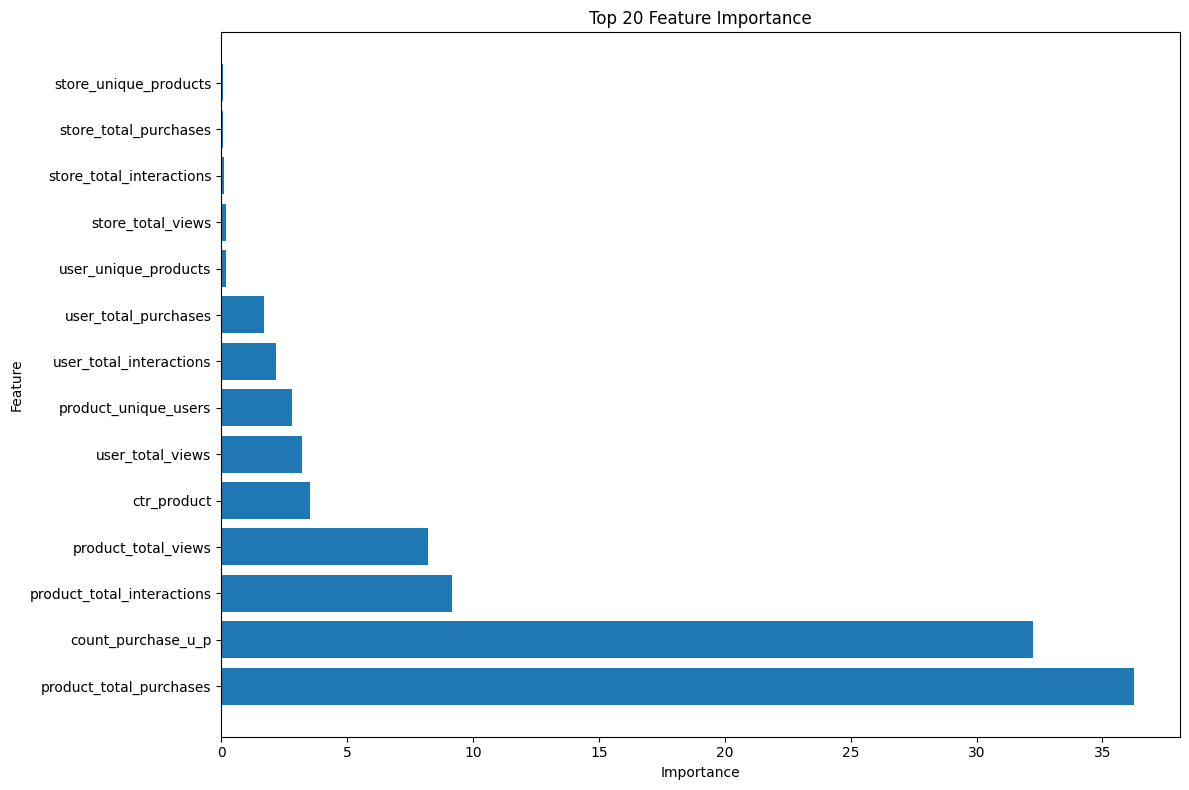

In [24]:
vis = Visualizer()
vis.plot_feature_importance(results['cv_results']['folds'][0]['feature_importance']);